In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [5]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

import numpy as np
 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# import theano
# theano.config.compute_test_value = "ignore"

<Figure size 432x288 with 0 Axes>

In [37]:
num_time_step = 10
forecast_num_time_step = 1
time_series_len = 10000
batch_size = 10
time_series = [np.sin(x) for x in np.linspace(0, 50, time_series_len)]

# plt.figure(figsize=(15,10))
# plt.plot(time_series)
# plt.show()

X_train = []
y_train = []
for i in range(len(time_series[num_time_step:-forecast_num_time_step])):
    X_train.append(time_series[i:i+num_time_step])
    y_train.append(time_series[i+num_time_step:i+num_time_step+forecast_num_time_step])

X_train = np.array(X_train).reshape((time_series_len - num_time_step - forecast_num_time_step,num_time_step, 1))
y_train = np.array(y_train)

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(num_time_step,1), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(num_time_step))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [38]:
y_train.shape

(9989, 1)

In [39]:
history = model.fit(X_train, y_train, 
          epochs = 10, 
          batch_size = batch_size, 
          verbose=1, 
#           validation_data=(X_train, y_train),
#           callbacks=[reduce_lr, checkpointer],
          shuffle=False)

Epoch 1/10
9989/9989 [==============================] - 39s 4ms/step - loss: 0.0616
Epoch 2/10
9989/9989 [==============================] - 35s 4ms/step - loss: 0.0725
Epoch 3/10
9989/9989 [==============================] - 44s 4ms/step - loss: 0.0859
Epoch 4/10
9989/9989 [==============================] - 42s 4ms/step - loss: 6901.2792
Epoch 5/10
9989/9989 [==============================] - 43s 4ms/step - loss: 0.5939
Epoch 6/10
9989/9989 [==============================] - ETA: 0s - loss: 10.03 - 41s 4ms/step - loss: 10.0273
Epoch 7/10
9989/9989 [==============================] - 43s 4ms/step - loss: 0.0282
Epoch 8/10
9989/9989 [==============================] - 39s 4ms/step - loss: 0.0191
Epoch 9/10
9989/9989 [==============================] - 31s 3ms/step - loss: 0.0137
Epoch 10/10
9989/9989 [==============================] - 30s 3ms/step - loss: 0.0118


In [40]:
%%time 
X_test = []
y_test = []
for i in log_progress(range(len(time_series[num_time_step:-forecast_num_time_step]))):
    X_test.append(model.predict(np.array(time_series[i:i+num_time_step]).reshape((-1,num_time_step, 1))))

X_test = np.array(X_test)

CPU times: user 1min 11s, sys: 13.5 s, total: 1min 25s
Wall time: 44.3 s


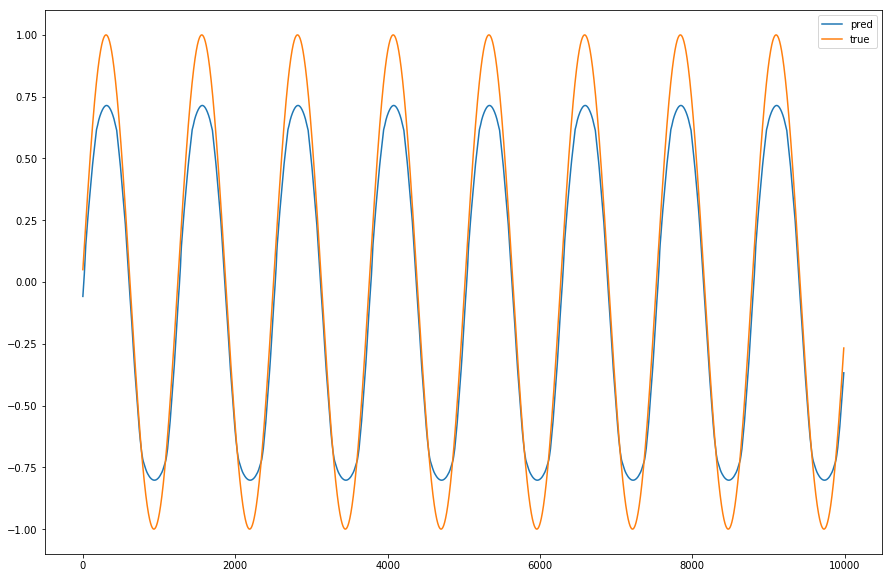

In [41]:
plt.figure(figsize=(15,10))
plt.plot(X_test.flatten())
plt.plot(time_series[num_time_step:-forecast_num_time_step])
plt.legend(['pred','true'], loc='best')
plt.show()